In [ ]:
python ../../optim/hippo_lv_tex_train.py --data_path /root/LV/LV/2502LV/AIBL/demented_mid_tgt/I133552_cuttail_L_opt_data.pkl --tag 2508  --learning_rate 0.0005 --sub_id I133552_noreg --gpu 3 --lda 1 3 2000 500 100 1 1 --epoch 5001

Namespace(gpu='3', batch_size=1, epoch=5001, learning_rate=0.0005, num_point=1024, data_path='/root/LV/LV/2502LV/AIBL/demented_mid_tgt/I1115156_cuttail_L_opt_data.pkl', tag='2508', sub_id='I1115156_noreg', lda=[1.0, 3.0, 2000.0, 500.0, 100.0, 1.0, 1.0])
I1115156_noreg !!!!!
Directory '/root/LV/LV_Shape_Modeling/ipynb/MICCAI-LV/results/2508/log/I1115156_noreg' created successfully.
Start training...
@@@@@!! I1115156_noreg
(16224, 3) !!!!!!!!!!!!
tensor(4.7714, device='cuda:0') tensor(52.3817, device='cuda:0') BASIC LOSS
lambda is following. 
 1. pm: 1.0
 2. cf 3.0
 3. edge 2000.0
 4. lap 500.0
 5. norm_con 100.0
 6. l2_vert 1.0
 7.l2_norm 1.0
  0%|                                                  | 0/5001 [00:00<?, ?it/s]0 {'loss': tensor(124.8886, device='cuda:0', grad_fn=<AddBackward0>), 'point_mesh_dist_loss': tensor(37.2016, device='cuda:0'), 'chamfer_loss': tensor(39.3927, device='cuda:0'), 'tri_point_mesh_dist_loss': tensor(69.6032, device='cuda:0'), 'tri_chamfer_loss': tensor(73.

In [ ]:
python ../../optim/hippo_lv_tex_train.py --data_path /root/LV/LV/2502LV/AIBL/demented_mid_tgt/I133552_cuttail_L_opt_data.pkl --tag 2508  --learning_rate 0.0005 --sub_id I133552_muchreg --gpu 3 --lda 1 3 2000 500 100 1 1 --epoch 5001

In [18]:
import os
import torch
import open3d as o3d

from tqdm import tqdm
import numpy as np
import trimesh
import pyvista as pv
import numbers
from pytorch3d.loss import chamfer_distance
import matplotlib.pyplot as plt
import pickle
# 일단은 파일 하나에 다 때려박아놓음

class SSMPCA:
    def __init__(self, correspondences):
        """
        Compute the SSM based on eigendecomposition.
        Args:
            correspondences:    Corresponded shapes as a torch.Tensor
        """
        self.device = correspondences.device
        self.mean = torch.mean(correspondences, dim=0)

        data_centered = correspondences - self.mean
        cov_dual = torch.matmul(data_centered, data_centered.T) / (
            data_centered.shape[0] - 1
        )

        evals, evecs = torch.linalg.eigh(cov_dual)
        evecs = torch.matmul(data_centered.t(), evecs)
        # Normalize the col-vectors
        evecs /= torch.sqrt(torch.sum(evecs ** 2, dim=0))

        # Sort
        idx = torch.argsort(evals, descending=True)
        evecs = evecs[:, idx]
        evals = evals[idx]

        # Remove the last eigenpair (it should have zero eigenvalue)
        self.variances = evals[:-1]
        self.modes_norm = evecs[:, :-1]
        # Compute the modes scaled by corresp. std. dev.
        self.modes_scaled = self.modes_norm * torch.sqrt(self.variances)
        self.modes_scaled = self.modes_scaled.to(torch.float32)
        self.length = evecs.shape[0]

    def generate_random_samples(self, n_samples=1, n_modes=None):
        """
        Generate random samples from the SSM.
        Args:
            n_samples:  number of samples to generate
            n_modes:    number of modes to use
        Returns:
            samples:    Generated random samples as torch.Tensor
        """
        if n_modes is None:
            n_modes = self.modes_scaled.shape[1]
        weights = torch.randn(n_samples, n_modes).to(self.device)
        samples = self.mean + torch.matmul(weights, self.modes_scaled.t()[:n_modes])
        return samples.squeeze()

    def get_reconstruction(self, shape, n_modes=None):
        """
        Project shape into the SSM to get a reconstruction
        Args:
            shape:      shape to reconstruct as torch.Tensor
            n_modes:    number of modes to use. If None, all relevant modes are used
        Returns:
            data_proj:  projected data as reconstruction as torch.Tensor
        """
        shape = shape.view(-1)
        data_proj = shape - self.mean
        if n_modes:
            # restrict to max number of modes
            if n_modes > self.length:
                n_modes = self.modes_scaled.shape[1]
            evecs = self.modes_norm[:, :n_modes]
        else:
            evecs = self.modes_norm
        evecs_t = evecs.t()
        data_proj_re = data_proj.view(-1, 1)
        weights = torch.matmul(evecs_t, data_proj_re)
        data_proj = self.mean + torch.matmul(weights.t(), evecs_t)
        data_proj = data_proj.view(-1, 3)
        return data_proj.float()

class SurfaceDistance():
    """This class calculates the symmetric vertex to surface distance of two
    trimesh meshes.
    """

    def __init__(self):
        pass

    def __call__(self, A, B):
        """
        Args:
          A: trimesh mesh
          B: trimesh mesh
        """
        _, A_B_dist, _ = trimesh.proximity.closest_point(A, B.vertices)
        _, B_A_dist, _ = trimesh.proximity.closest_point(B, A.vertices)
        distance = .5 * np.array(A_B_dist).mean() + .5 * \
            np.array(B_A_dist).mean()

        return np.array([distance])

def calculate_generalization_point(ssm_model, test_data_path, deformed_testing_shapes, logger, device, output_path):
    
    generalization_mean = []
    generalization_std = []
    print(f'Calculating Generalization')
    
    for mode in tqdm(range(1, ssm_model.variances.shape[0] + 1)):
        generalization_per_mode = []
        
        for index, test_data in enumerate(os.listdir(test_data_path)):
            if index<10:
                original_verts = np.loadtxt(os.path.join(test_data_path, test_data))
                # original_faces = np.asarray(read_vtk_mesh(os.path.join(test_data_path, test_data)).triangles)
                recon_deformed_shape = (ssm_model.get_reconstruction(deformed_testing_shapes[index], n_modes=mode)
                                        .reshape(1, -1, 3).to(device)).float()
                
                original_verts = torch.tensor(original_verts).reshape(1, -1, 3).to(device).float()
                recon_deformed_shape = recon_deformed_shape.reshape(1, -1, 3).to(device).float()
                
                dist, _ = chamfer_distance(original_verts, recon_deformed_shape, point_reduction=None, batch_reduction=None)
                surf_dist = 0.5 * (dist[0].sqrt().mean(dim=1) + dist[1].sqrt().mean(dim=1))
                surf_dist = to_numpy(surf_dist)
                
                generalization_per_mode.append(surf_dist)
            
        generalization_per_mode_mean = np.mean(generalization_per_mode)
        generalization_per_mode_std = np.std(generalization_per_mode)
        generalization_mean.append(generalization_per_mode_mean)
        generalization_std.append(generalization_per_mode_std)
        print(f'Generalizations for mode {mode} is {generalization_per_mode_mean:.4f} +/- {generalization_per_mode_std:.4f}')
        
    generalization_mean = np.array(generalization_mean)
    generalization_std = np.array(generalization_std)
    return generalization_mean
import numpy as np
def calculate_specificity(ssm_model, train_data_path, logger, device, output_path):
    n_samples = 1000
    specificity_mean = []
    specificity_std = []
    print(f'Calculating Specificity...')

    for mode in tqdm(range(1, ssm_model.variances.shape[0] + 1)):
        samples = ssm_model.generate_random_samples(n_samples=n_samples, n_modes=mode)
        samples = samples.reshape(n_samples, -1, 3).to(device)
        # samples = samples - samples.mean(dim=1, keepdim=True)

        distances = np.zeros((n_samples, len(os.listdir(train_data_path))))
        # np.random.choice(gt_data.shape[0], 4000, replace=False)
        for index, data in enumerate(os.listdir(train_data_path)):

            tgt_pt = np.loadtxt(os.path.join(train_data_path, data))
            
            
            target = torch.tensor(tgt_pt).to(device)
            target = torch.tensor(tgt_pt).to(device)
            target = target.repeat(n_samples, 1, 1)
            
            loss, _ = chamfer_distance(target.float(), samples.float(), point_reduction=None, batch_reduction=None)
            distance = 0.5 * (loss[0].sqrt().mean(dim=1) + loss[1].sqrt().mean(dim=1))

            distance = to_numpy(distance)
            distances[:, index] = distance

        specificity_mean_value = distances.min(1).mean()
        specificity_std_value = distances.min(1).std()
        specificity_mean.append(specificity_mean_value)
        specificity_std.append(specificity_std_value)
        print(f'Specificity for mode {mode} is {specificity_mean_value:.2f} +/- {specificity_std_value:.2f}')
        
    specificity_mean = np.array(specificity_mean)
    specificity_std = np.array(specificity_std)
    return specificity_mean
    
def calculate_compactness(ssm_model, train_data_path, logger, device, output_path):
    n_samples = 1000
    compactness_full = []
    print(f'Calculating Compactness...')
    
    eigenvalues = ssm_model.variances
    sum_eigenvalues = torch.sum(eigenvalues)
    
    temp = 0
    for mode in tqdm(range(1, ssm_model.variances.shape[0] + 1)):
        temp += eigenvalues[mode - 1]
        compactness = temp / sum_eigenvalues
        compactness_full.append(to_numpy(compactness))
        print(f'Compactness for mode {mode} is {compactness:.10f}')

    result_path = os.path.join(output_path, "compactness.png")
    compactness_full = np.array(compactness_full)
    plot_with_std(np.array(list(range(1, ssm_model.variances.shape[0] + 1))),
                  compactness_full, 0,
                  "Compactness", result_path, y_label='Explained variance')
    # np.save(os.path.join(output_path, "compactness.npy"), compactness_full)
    print(compactness_full)
    return compactness_full
    
# vtk 파일 읽어서 o3d mesh로 변환    
def read_vtk_mesh(file_path):
    mesh = pv.read(file_path)
    vertices = mesh.points
    faces = mesh.faces.reshape(-1, 4)[:, 1:]
    mesh_o3d = o3d.geometry.TriangleMesh()
    mesh_o3d.vertices = o3d.utility.Vector3dVector(vertices)
    mesh_o3d.triangles = o3d.utility.Vector3iVector(faces)
    mesh_o3d.compute_vertex_normals()
    return mesh_o3d

def to_numpy(tensor, squeeze=True):
    """Wrapper around .detach().cpu().numpy() """
    if isinstance(tensor, torch.Tensor):
        if squeeze:
            tensor = tensor.squeeze()
        return tensor.detach().cpu().numpy()
    elif isinstance(tensor, np.ndarray):
        return tensor
    elif isinstance(tensor, numbers.Number):
        return np.array([tensor])
    else:
        raise NotImplementedError()


def plot_with_std(x, y_mean, y_std, title, path, y_label='Error'):
    # Plot the mean line
    plt.plot(x, y_mean, label='Mean')

    # Plot the shaded region for standard deviation
    plt.fill_between(x, y_mean - y_std, y_mean + y_std, alpha=0.3, label='std')

    # Add labels and legend
    plt.xlabel('Modes')
    plt.ylabel(y_label)
    plt.title(title)
    plt.legend()

    # save plot
    plt.savefig(path)
    plt.close()


In [20]:
device ="cuda:0"

import glob
import pickle
for dataset in ["OASIS","ADNI","AIBL"]:
    for type_nd in ["demented","normal"]:
        c_dict, g_dict, s_dict = {}, {}, {}
        for model in ["ours_tex2"]:#ours","ours-tex","ptnet","miua"]: #"lddmm","sw"
            gt_datas= []
            subs= []
            for data in (glob.glob(f"/root/LV/ssm_eval/{dataset}/points/{type_nd}/gt/*.pkl")):
                sub=data.split("/")[-1].split(".")[0]
                subs.append(sub)
                gt_data = pickle.load(open(data, "rb"))['lv']
                gt_data = gt_data[np.random.choice(gt_data.shape[0], 4000, replace=False)]
                gt_datas.append(gt_data)
            gt_datas = np.asarray(gt_datas)
            gt_datas = torch.tensor(gt_datas).to(device)
            ind = np.random.choice(4096, 2490, replace=False)
            deformed_training_shapes = []
            for sub in subs:    
                test_data = np.loadtxt(f"/root/LV/ssm_eval/{dataset}/points/{type_nd}/{model}/{sub}.txt")
                deformed_training_shapes.append(test_data)
                print(test_data.shape)
            deformed_training_shapes = np.asarray(deformed_training_shapes)
            deformed_training_shapes = torch.tensor(deformed_training_shapes).to(device)
            print(deformed_training_shapes.shape)
            deformed_training_shapes = deformed_training_shapes.reshape(deformed_training_shapes.shape[0], -1)
            print(deformed_training_shapes.shape)
            ssm_model = SSMPCA(deformed_training_shapes)
            g= calculate_generalization_point(ssm_model, f"/root/LV/ssm_eval/{dataset}/points/{type_nd}/{model}",deformed_training_shapes[:15],"", device, "./")

            c= calculate_compactness(ssm_model, "a", "b", device, "./")
            print(c)
            s= calculate_specificity(ssm_model, f"/root/LV/ssm_eval/{dataset}/points/{type_nd}/{model}", "", device, "./")
            print(s)
            ssm_model = SSMPCA(deformed_training_shapes[15:])
            c_dict[model]=c
            g_dict[model]=g
            s_dict[model]=s
        pickle.dump(c_dict, open(f"/root/LV/ssm_eval/{dataset}/{type_nd}_c_ours_tex_2.pkl", "wb"))
        pickle.dump(g_dict, open(f"/root/LV/ssm_eval/{dataset}/{type_nd}_g_ours_tex_.pkl", "wb"))
        pickle.dump(s_dict, open(f"/root/LV/ssm_eval/{dataset}/{type_nd}_s_ours_tex_.pkl", "wb"))

(2490, 3)


FileNotFoundError: /root/LV/ssm_eval/OASIS/points/demented/ours_tex2/OAS1_0031_MR1.txt not found.

dict_keys(['ours', 'ours-tex', 'ptnet', 'miua'])
dict_keys(['lddmm', 'miua', 'ours', 'ours-tex', 'ptnet', 'sw'])
dict_keys(['ours_tex4', 'real_miua1000'])
34
34
34
34
ADNI-normal_g


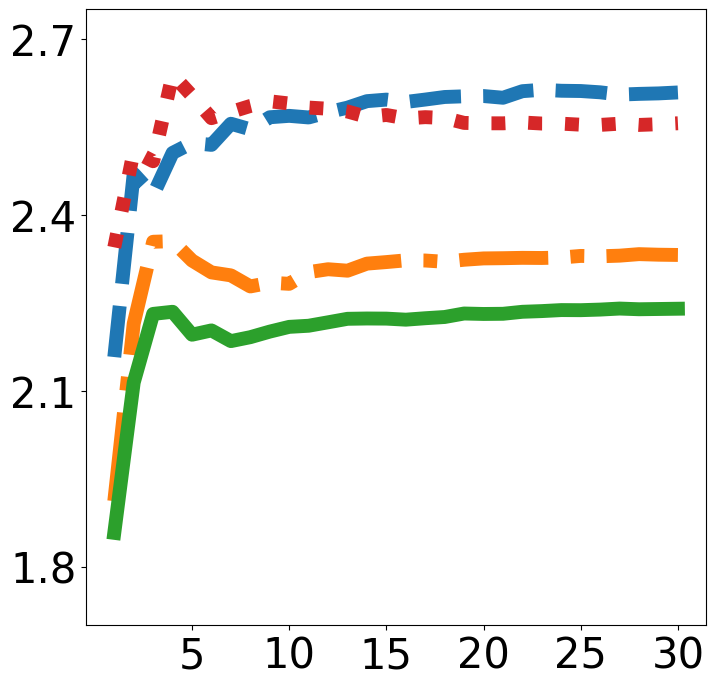

dict_keys(['ours', 'ours-tex', 'ptnet', 'miua'])
dict_keys(['lddmm', 'miua', 'ours', 'ours-tex', 'ptnet', 'sw'])
dict_keys(['ours_tex4', 'real_miua1000'])
49
49
49
49
ADNI-normal_s


<Figure size 640x480 with 0 Axes>

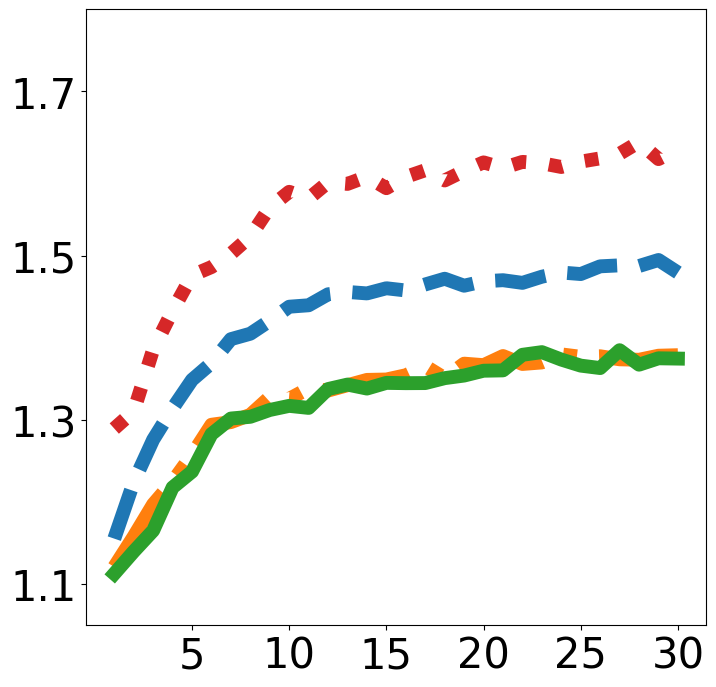

dict_keys(['ours', 'ours-tex', 'ptnet', 'miua'])
dict_keys(['lddmm', 'miua', 'ours', 'ours-tex', 'ptnet', 'sw'])
dict_keys(['ours_tex4', 'real_miua1000'])
49
49
49
49
ADNI-normal_c


<Figure size 640x480 with 0 Axes>

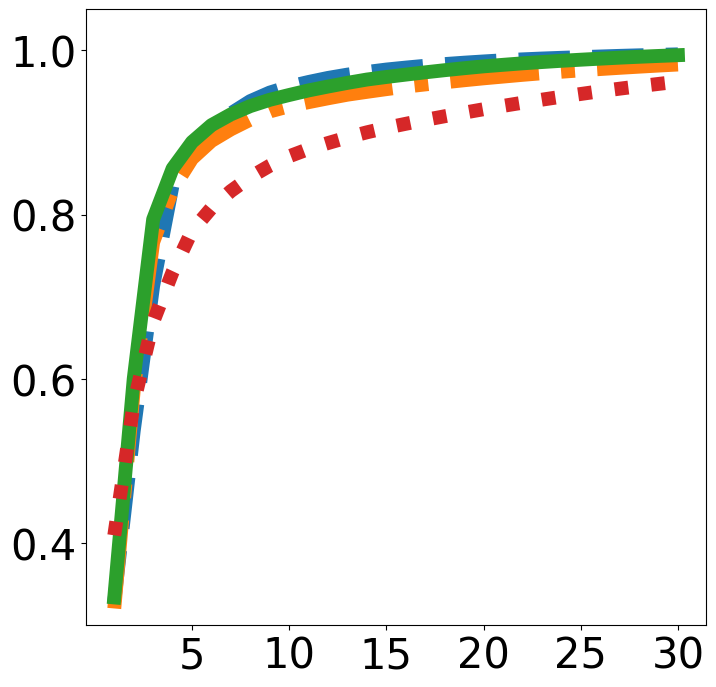

dict_keys(['ours', 'ours-tex', 'ptnet', 'miua'])
dict_keys(['lddmm', 'miua', 'ours', 'ours-tex', 'ptnet', 'sw'])
dict_keys(['ours_tex4', 'real_miua1000'])
34
34
34
34
ADNI-demented_g


<Figure size 640x480 with 0 Axes>

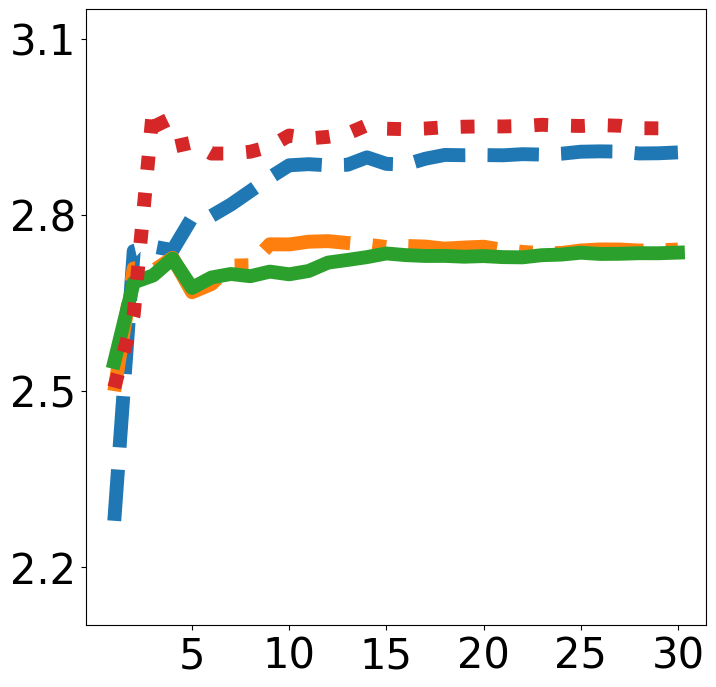

dict_keys(['ours', 'ours-tex', 'ptnet', 'miua'])
dict_keys(['lddmm', 'miua', 'ours', 'ours-tex', 'ptnet', 'sw'])
dict_keys(['ours_tex4', 'real_miua1000'])
49
49
49
49
ADNI-demented_s


<Figure size 640x480 with 0 Axes>

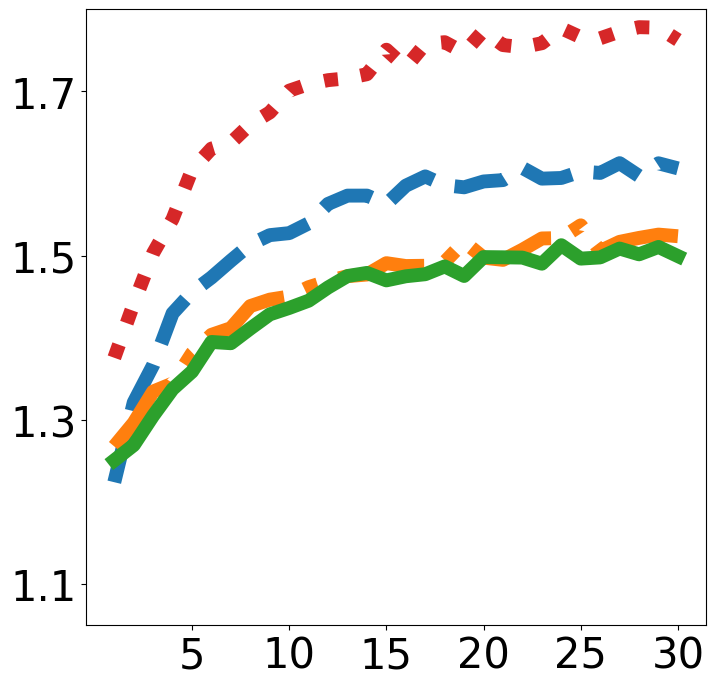

dict_keys(['ours', 'ours-tex', 'ptnet', 'miua'])
dict_keys(['lddmm', 'miua', 'ours', 'ours-tex', 'ptnet', 'sw'])
dict_keys(['ours_tex4', 'real_miua1000'])
49
49
49
49
ADNI-demented_c


<Figure size 640x480 with 0 Axes>

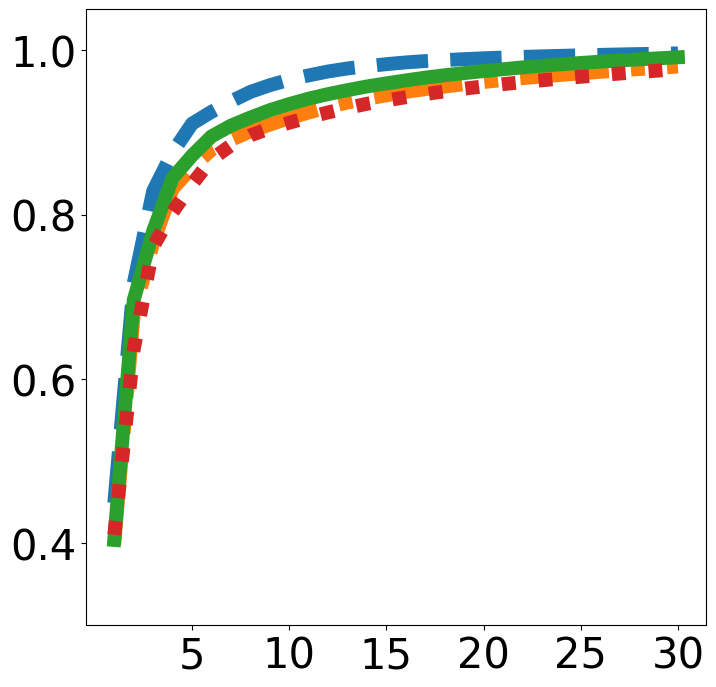

dict_keys(['ours', 'ours-tex', 'ptnet', 'miua'])
dict_keys(['lddmm', 'miua', 'ours', 'ours-tex', 'ptnet', 'sw'])
dict_keys(['ours_tex4', 'real_miua1000'])
34
34
34
34
AIBL-normal_g


<Figure size 640x480 with 0 Axes>

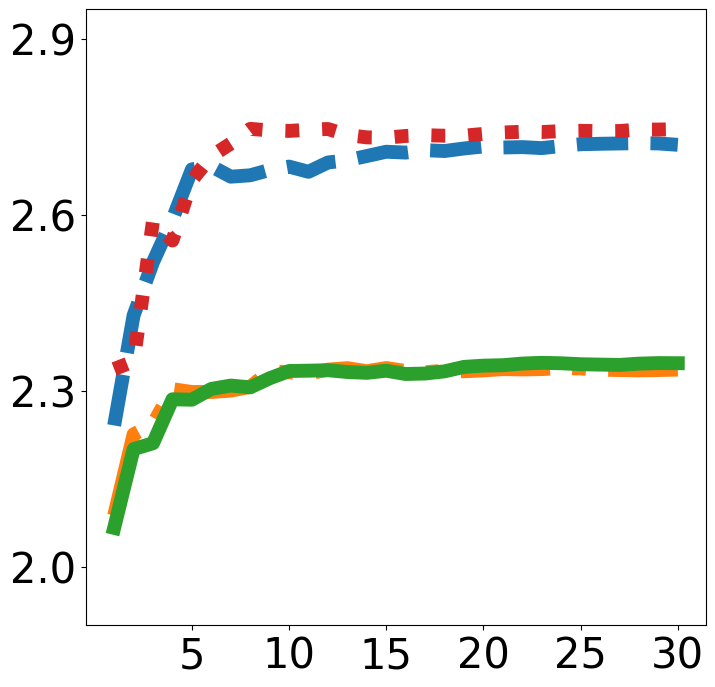

dict_keys(['ours', 'ours-tex', 'ptnet', 'miua'])
dict_keys(['lddmm', 'miua', 'ours', 'ours-tex', 'ptnet', 'sw'])
dict_keys(['ours_tex4', 'real_miua1000'])
49
49
49
49
AIBL-normal_s


<Figure size 640x480 with 0 Axes>

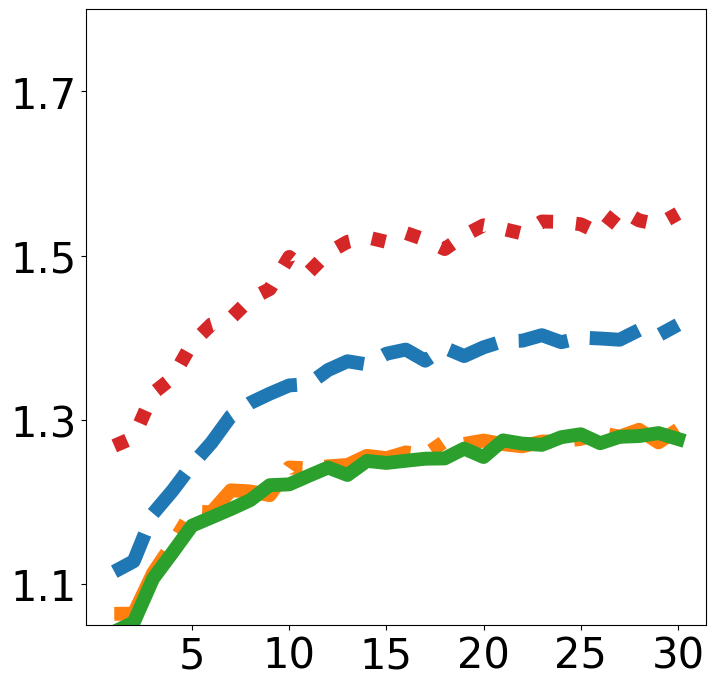

dict_keys(['ours', 'ours-tex', 'ptnet', 'miua'])
dict_keys(['lddmm', 'miua', 'ours', 'ours-tex', 'ptnet', 'sw'])
dict_keys(['ours_tex4', 'real_miua1000'])
49
49
49
49
AIBL-normal_c


<Figure size 640x480 with 0 Axes>

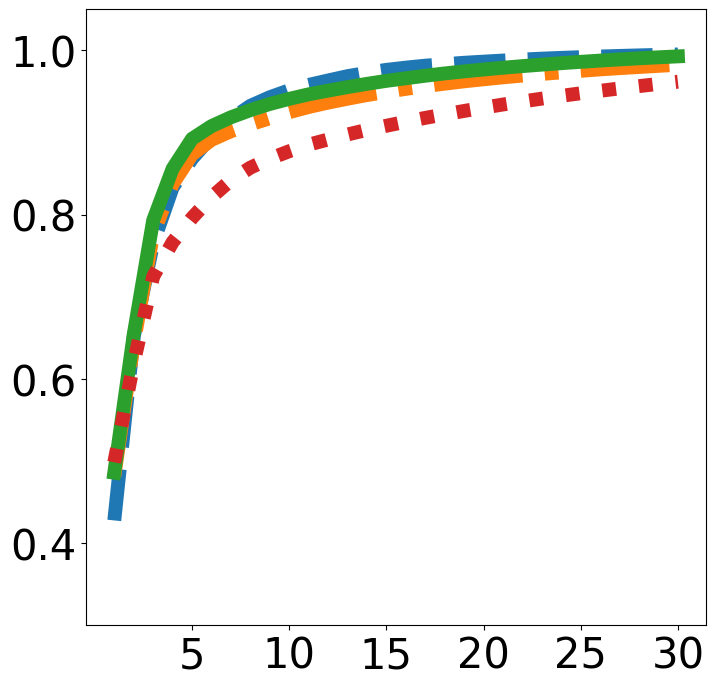

dict_keys(['ours', 'ours-tex', 'ptnet', 'miua'])
dict_keys(['lddmm', 'miua', 'ours', 'ours-tex', 'ptnet', 'sw'])
dict_keys(['ours_tex4', 'real_miua1000'])
34
34
34
34
AIBL-demented_g


<Figure size 640x480 with 0 Axes>

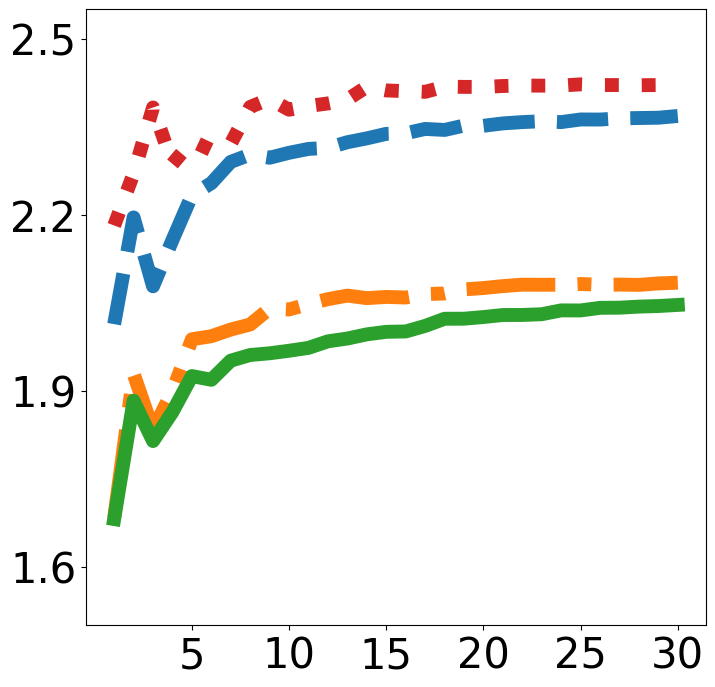

dict_keys(['ours', 'ours-tex', 'ptnet', 'miua'])
dict_keys(['lddmm', 'miua', 'ours', 'ours-tex', 'ptnet', 'sw'])
dict_keys(['ours_tex4', 'real_miua1000'])
49
49
49
49
AIBL-demented_s


<Figure size 640x480 with 0 Axes>

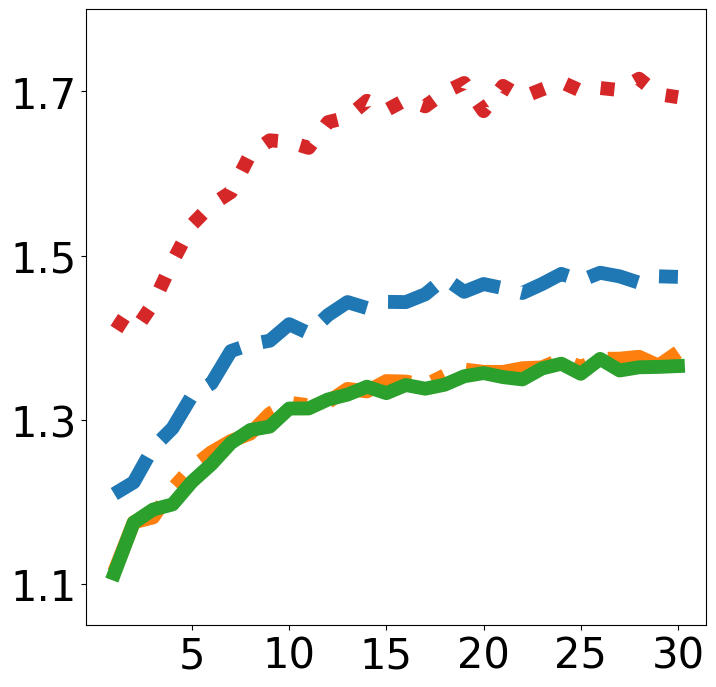

dict_keys(['ours', 'ours-tex', 'ptnet', 'miua'])
dict_keys(['lddmm', 'miua', 'ours', 'ours-tex', 'ptnet', 'sw'])
dict_keys(['ours_tex4', 'real_miua1000'])
49
49
49
49
AIBL-demented_c


<Figure size 640x480 with 0 Axes>

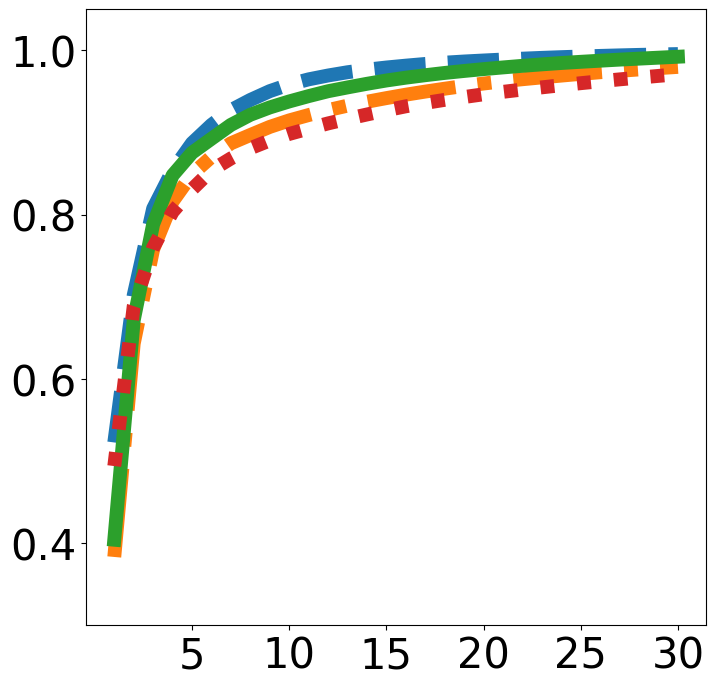

dict_keys(['ours', 'ours-tex', 'ptnet', 'miua'])
dict_keys(['lddmm', 'miua', 'ours', 'ours-tex', 'ptnet', 'sw'])
dict_keys(['ours_tex4', 'real_miua1000'])
34
34
34
34
OASIS-normal_g


<Figure size 640x480 with 0 Axes>

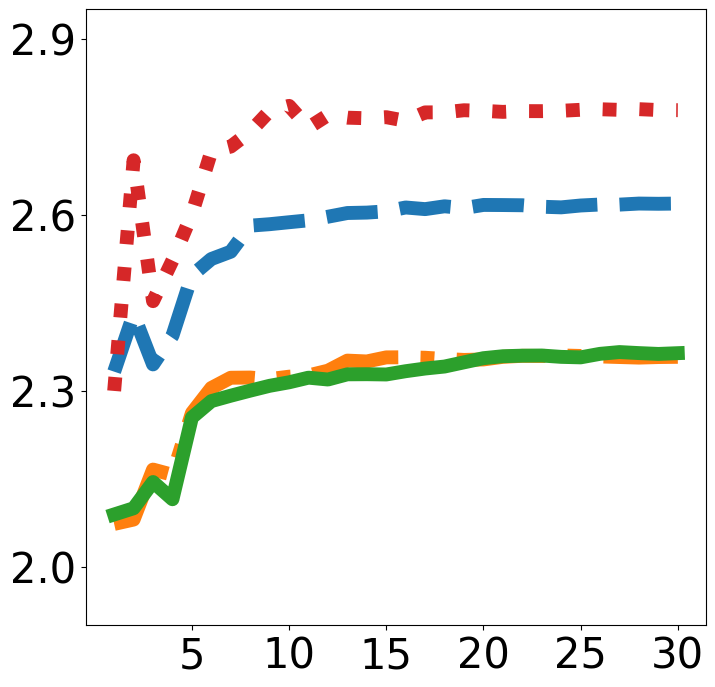

dict_keys(['ours', 'ours-tex', 'ptnet', 'miua'])
dict_keys(['lddmm', 'miua', 'ours', 'ours-tex', 'ptnet', 'sw'])
dict_keys(['ours_tex4', 'real_miua1000'])
49
49
49
49
OASIS-normal_s


<Figure size 640x480 with 0 Axes>

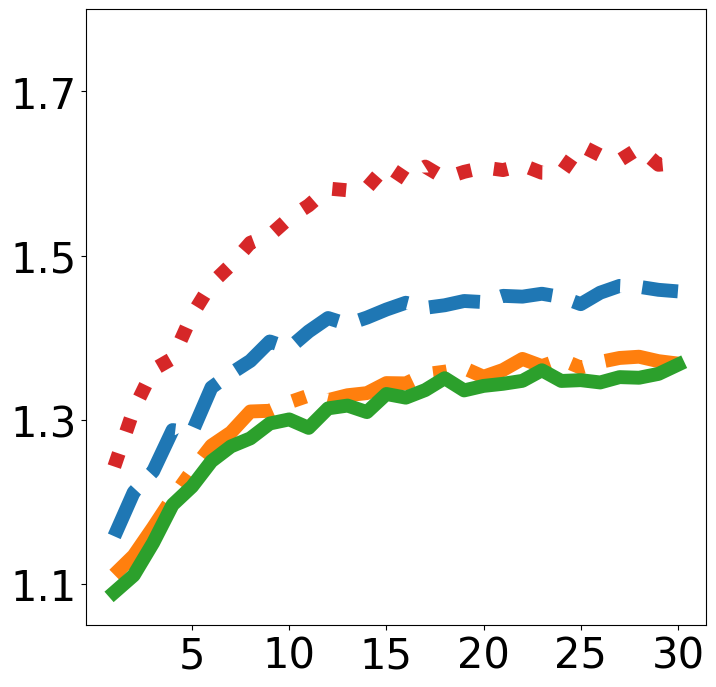

dict_keys(['ours', 'ours-tex', 'ptnet', 'miua'])
dict_keys(['lddmm', 'miua', 'ours', 'ours-tex', 'ptnet', 'sw'])
dict_keys(['ours_tex4', 'real_miua1000'])
49
49
49
49
OASIS-normal_c


<Figure size 640x480 with 0 Axes>

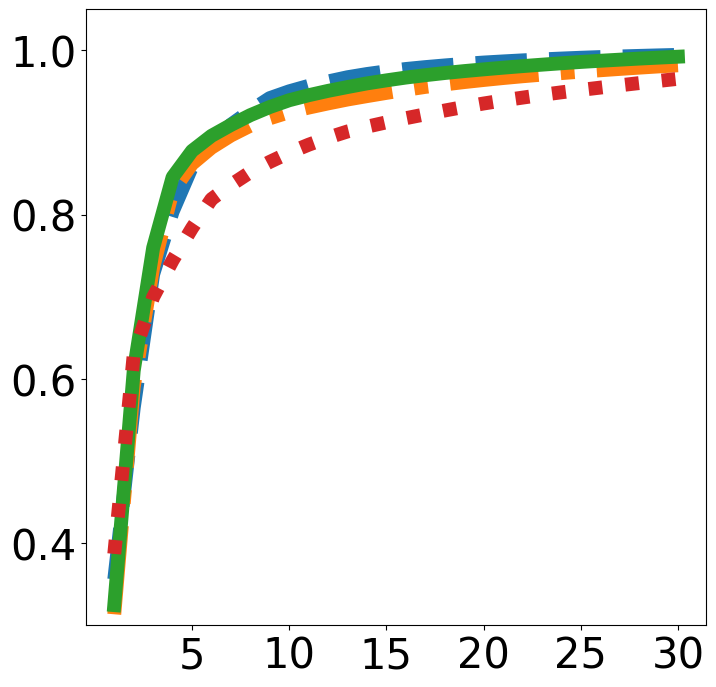

dict_keys(['ours', 'ours-tex', 'ptnet', 'miua'])
dict_keys(['lddmm', 'miua', 'ours', 'ours-tex', 'ptnet', 'sw'])
dict_keys(['ours_tex4', 'real_miua1000'])
34
34
34
34
OASIS-demented_g


<Figure size 640x480 with 0 Axes>

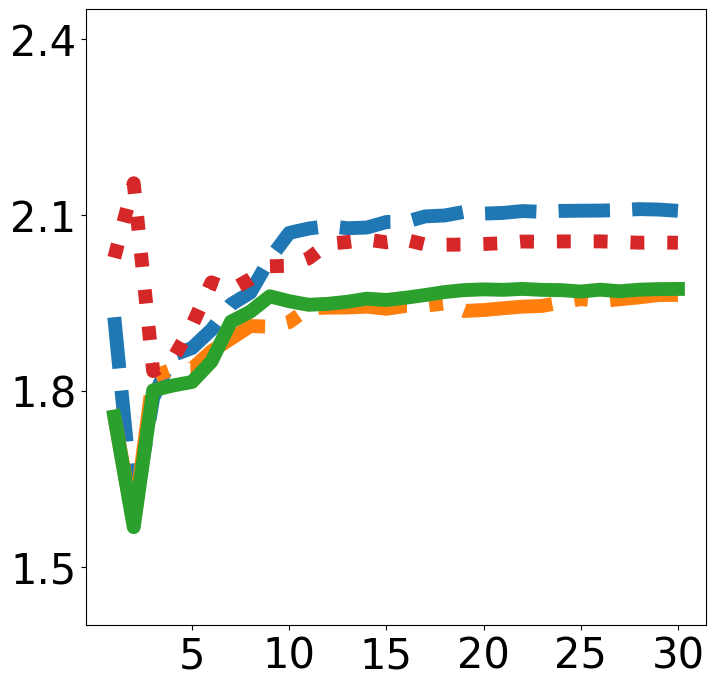

dict_keys(['ours', 'ours-tex', 'ptnet', 'miua'])
dict_keys(['lddmm', 'miua', 'ours', 'ours-tex', 'ptnet', 'sw'])
dict_keys(['ours_tex4', 'real_miua1000'])
49
49
49
49
OASIS-demented_s


<Figure size 640x480 with 0 Axes>

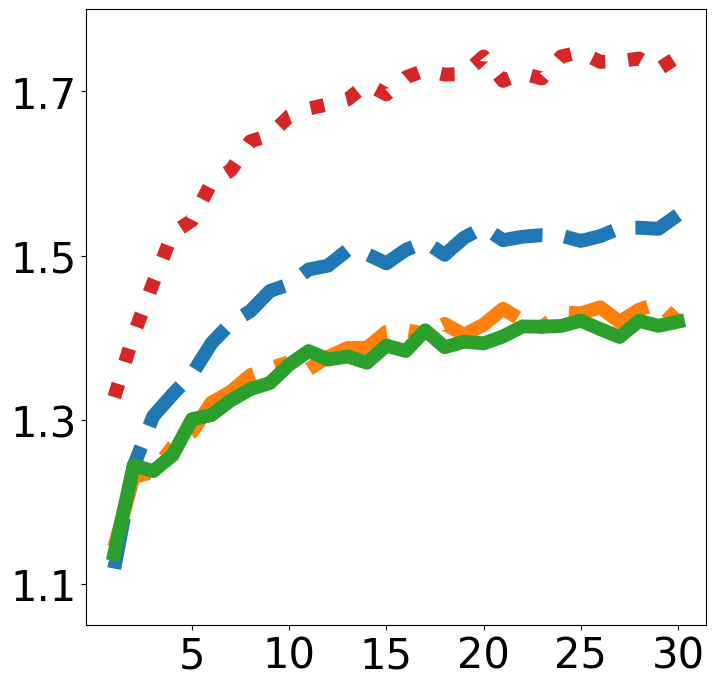

dict_keys(['ours', 'ours-tex', 'ptnet', 'miua'])
dict_keys(['lddmm', 'miua', 'ours', 'ours-tex', 'ptnet', 'sw'])
dict_keys(['ours_tex4', 'real_miua1000'])
49
49
49
49
OASIS-demented_c


<Figure size 640x480 with 0 Axes>

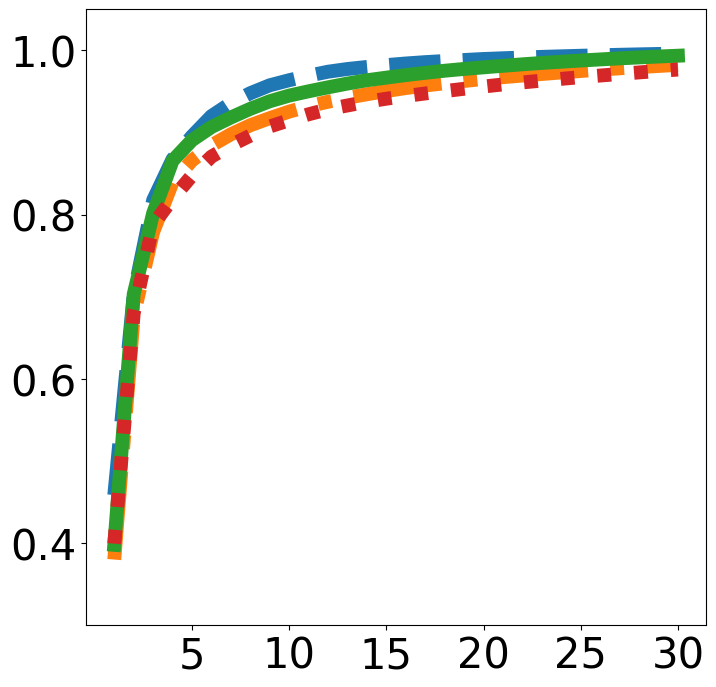

<Figure size 640x480 with 0 Axes>

In [50]:
import matplotlib.pyplot as plt

# 데이터
# data = {
#     "데이터 1": [12, 15, 18, 11, 14, 16, 13, 17, 19, 20, 22, 21, 23, 24, 25, 23, 22, 20, 18, 17, 16, 14, 13, 11, 10],
#     "데이터 2": [8, 10, 12, 9, 11, 13, 10, 12, 14, 15, 17, 16, 18, 19, 20, 19, 18, 16, 14, 13, 12, 10, 9, 8, 7],
#     "데이터 3": [5, 7, 9, 6, 8, 10, 7, 9, 11, 12, 14, 13, 15, 16, 17, 16, 15, 13, 11, 10, 9, 7, 6, 5, 4],
#     "데이터 4": [2, 4, 6, 3, 5, 7, 4, 6, 8, 9, 11, 10, 12, 13, 14, 13, 12, 10, 8, 7, 6, 4, 3, 2, 1],
# }
for dataset in ["ADNI","AIBL","OASIS"]:
    for type_nd in ["normal","demented"]:
        for metric in ["g","s","c"]:
            data2 = pickle.load(open(f"/root/LV/ssm_eval/{dataset}/{type_nd}_{metric}.pkl", "rb"))

            # data = pickle.load(open(f"/root/LV/ssm_eval/{dataset}/{type_nd}_{metric}_ours2.pkl", "rb"))
            # print(data.keys())
            data3 ={}
            data4 = pickle.load(open(f"/root/LV/ssm_eval/{dataset}/{type_nd}_{metric}_sw.pkl", "rb"))
            data5 = pickle.load(open(f"/root/LV/ssm_eval/{dataset}/{type_nd}_{metric}_peri.pkl", "rb"))
            data5 = pickle.load(open(f"/root/LV/ssm_eval/{dataset}/{type_nd}_{metric}_ptnet.pkl", "rb"))
            print(data5.keys())
            # data6 = pickle.load(open(f"/root/LV/ssm_eval/{dataset}/{type_nd}_{metric}_ours_miua.pkl", "rb"))
            print(data2.keys())
            print(data6.keys())
            # data3["miua"]= data6["real_miua1000"]
            data3["miua"]= data5["miua"]
            data3["ours-tex"] = data2["ours"]
            data3["lddmm"] = data2["lddmm"]
            data3["sw"] = data4["sw"]
            
            # remove 
            # 색상 목록
            colors = ['#41afaa', '#466eb4', '#00a0e1', '#e6a532', '#d7642c', '#af4b91'] 

            # 그래프 그리기
            plt.figure(figsize=(8,8))  # 그래프 크기 설정 (선택 사항)
            x_values = range(1,31) 
            y_small = 5
            for i, (label, values) in enumerate(data3.items()):
                print(len(values))
                # plt.plot(x_values, values[:34], label=label, linewidth=2)#, color=colors[i]
                y_small = min(y_small, min(values[:34]))
                
            # 선 종류 리스트
            linestyles = ['-', '-.','--', ':']

            # 그래프 그리기 (각 선의 종류 다르게 설정)
            if metric =="g":
            # # g-setting 
                plt.plot(x_values, data3["lddmm"][:30], linestyle=linestyles[2], label="lddmm", linewidth=10)
                plt.plot(x_values, data3["ours-tex"][:30], linestyle=linestyles[1], label="miua", linewidth=10)
                plt.plot(x_values, data3["miua"][:30], linestyle=linestyles[0], label="ours", linewidth=10)
                plt.plot(x_values, data3["sw"][:30], linestyle=linestyles[3], label="sw", linewidth=10)
                
                # print(y_small)
                import math
                y_small = math.floor(y_small * 10) / 10 
                plt.tick_params(axis='both', which='major', labelsize=30) 
                
                plt.xticks(range(5, 31, 5))  # # x축 눈금 설정 (0부터 24까지 5 단위로)
                plt.yticks(np.arange(y_small,y_small+0.92, 0.3))   # # x축 눈금 설정 (0부터 24까지 5 단위로)
                plt.ylim(y_small-0.1,y_small+0.95)
            elif metric =="s":
                # s-setting
                plt.plot(x_values, data3["lddmm"][:30], linestyle=linestyles[2], label="lddmm", linewidth=10)
                plt.plot(x_values, data3["miua"][:30], linestyle=linestyles[1], label="miua", linewidth=10)
                plt.plot(x_values, data3["ours-tex"][:30]-0.0025, linestyle=linestyles[0], label="ours", linewidth=10)
                plt.plot(x_values, data3["sw"][:30], linestyle=linestyles[3], label="sw", linewidth=10)
                # print(y_small)
                import math
                y_small = math.floor(y_small * 10) / 10 
                plt.tick_params(axis='both', which='major', labelsize=30) 
                
                plt.xticks(range(5, 31, 5))  # # x축 눈금 설정 (0부터 24까지 5 단위로)
                plt.yticks(np.arange(1.1,1.8, 0.2))   # # x축 눈금 설정 (0부터 24까지 5 단위로)
                plt.ylim(1.05,1.8)
            elif metric=="c":
                # c-setting
                plt.plot(x_values, data3["lddmm"][:30], linestyle=linestyles[2], label="LDDMM", linewidth=10)
                plt.plot(x_values, data3["miua"][:30]-0.004, linestyle=linestyles[1], label="PeriNet", linewidth=10)
                plt.plot(x_values, data3["ours-tex"][:30]+0.004, linestyle=linestyles[0], label="Ours", linewidth=10)
                plt.plot(x_values, data3["sw"][:30], linestyle=linestyles[3], label="ShapeWorks", linewidth=10)
                # print(y_small)
                import math
                y_small = math.floor(y_small * 10) / 10 
                plt.tick_params(axis='both', which='major', labelsize=30) 
                
                plt.xticks(range(5, 31, 5))  # # x축 눈금 설정 (0부터 24까지 5 단위로)
                plt.yticks(np.arange(0.4,1.05, 0.2))   # # x축 눈금 설정 (0부터 24까지 5 단위로)
                plt.ylim(0.3,1.05)
            
            
            
            # y축 설정 (선택 사항)
            # plt.ylabel("Generalizability")
            # plt.xlabel("Mode")
            # 제목 설정 (선택 사항)
            # plt.title(f"{dataset}-{type_nd}")

            # 범례 표시
            # plt.legend()

            # 격자 표시 (선택 사항)
            # plt.grid(True)
    
            # 그래프 보여주기
            print(f"{dataset}-{type_nd}_{metric}")
            plt.show()
            # plt.legend(fontsize=30,ncol=4,loc='upper left', bbox_to_anchor=(1, 1))
            # plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
            
            plt.savefig(f"/root/LV/ssm_eval/{dataset}-{type_nd}_{metric}.png") 

In [134]:
print(data.keys())

dict_keys(['ours', 'ours-tex', 'ptnet', 'miua'])


In [3]:
import os
for dataset in ["ADNI","OASIS", "AIBL"]:
    os.makedirs(rf"G:\WJ\{dataset}\points", exist_ok=True)
    os.makedirs(rf"G:\WJ\{dataset}\points\normal", exist_ok=True)
    os.makedirs(rf"G:\WJ\{dataset}\points\demented", exist_ok=True)
    for type_nd in ["normal", "demented"]:
        os.makedirs(rf"G:\WJ\{dataset}\points\{type_nd}\lddmm", exist_ok=True)
        os.makedirs(rf"G:\WJ\{dataset}\points\{type_nd}\sw", exist_ok=True)
        os.makedirs(rf"G:\WJ\{dataset}\points\{type_nd}\miua", exist_ok=True)
        os.makedirs(rf"G:\WJ\{dataset}\points\{type_nd}\ptnet", exist_ok=True)
        os.makedirs(rf"G:\WJ\{dataset}\points\{type_nd}\ours", exist_ok=True)
        os.makedirs(rf"G:\WJ\{dataset}\points\{type_nd}\ours-tex", exist_ok=True)
        os.makedirs(rf"G:\WJ\{dataset}\points\{type_nd}\gt", exist_ok=True)

In [19]:
#GT
import glob
import shutil
from util import * 
for dataset in ["ADNI","OASIS", "AIBL"]:
    for type_nd in ["normal", "demented"]:
        
        subs = read_sub_from_csv(rf"G:\WJ\{dataset}\optim_eval\{dataset.lower()}_{type_nd}_tex.csv", flag="")[10:60]
        print(subs)
        folder = glob.glob(rf"G:\WJ\{dataset}\{type_nd}_tgt\*.pkl")
        for file in folder:
            file_name = file.split("\\")[-1]
           
            file_name = file_name.replace("_cuttail_L_opt_data", "")
            sub = file_name.split(".")[0]
            if sub in subs:
                shutil.copy(file, rf"G:\WJ\{dataset}\points\{type_nd}\gt\{file_name}") 

['I1083042', 'I373519', 'I47327', 'I1009810', 'I296878', 'I1221673', 'I1151456', 'I1002374', 'I1639219', 'I1558064', 'I1346790', 'I51292', 'I45146', 'I319400', 'I1491025', 'I398531', 'I1427086', 'I389994', 'I1456305', 'I362894', 'I1555916', 'I1346240', 'I384900', 'I384082', 'I497118', 'I1634180', 'I391278', 'I389908', 'I1037803', 'I1560259', 'I1017836', 'I1344288', 'I1021530', 'I503156', 'I319424', 'I1639974', 'I1003400', 'I1590171', 'I395111', 'I1029013', 'I499406', 'I429583', 'I1037417', 'I346460', 'I308178', 'I259796', 'I311862', 'I314576', 'I421732', 'I513714']
['I390300', 'I343977', 'I378271', 'I27049', 'I295023', 'I37420', 'I1253903', 'I388134', 'I393061', 'I1697549', 'I1611592', 'I348644', 'I297848', 'I35429', 'I31252', 'I387580', 'I388204', 'I1386023', 'I394014', 'I387450', 'I384923', 'I391599', 'I390348', 'I346967', 'I1431781', 'I378976', 'I118390', 'I380190', 'I366568', 'I1563078', 'I1584529', 'I393747', 'I393431', 'I336555', 'I1484349', 'I1440205', 'I334663', 'I379432', 'I38

In [ ]:
#GT
import glob
import shutil
from util import * 
for dataset in ["ADNI","OASIS", "AIBL"]:
    for type_nd in ["normal", "demented"]:
        
        subs = read_sub_from_csv(rf"G:\WJ\{dataset}\optim_eval\{dataset.lower()}_{type_nd}_tex.csv", flag="")[10:60]
        print(subs)
        folder = glob.glob(rf"G:\WJ\{dataset}\{type_nd}_tgt\*.pkl")
        for file in folder:

            if sub in subs:
                
                data = pickle.load(open(file, "rb"))
                tgt_pcd = data["lv"]
                tgt_pcd = o3d.geometry.PointCloud(points = o3d.utility.Vector3dVector(tgt_pcd))
                
                tgt_data = np.asarray(nib.load(rf"G:\WJ\{dataset}\{type_nd}_sw_tgt\data\{sub}.nii.gz").get_fdata())
                target_pcd_sw = voxel_to_bd_pcd((tgt_data))
                target_pcd_sw.paint_uniform_color([0, 0, 1])
                tgt_pcd.paint_uniform_color([1, 0, 0])
                o3d.visualization.draw_geometries([target_pcd_sw, tgt_pcd])
                

['I1083042', 'I373519', 'I47327', 'I1009810', 'I296878', 'I1221673', 'I1151456', 'I1002374', 'I1639219', 'I1558064', 'I1346790', 'I51292', 'I45146', 'I319400', 'I1491025', 'I398531', 'I1427086', 'I389994', 'I1456305', 'I362894', 'I1555916', 'I1346240', 'I384900', 'I384082', 'I497118', 'I1634180', 'I391278', 'I389908', 'I1037803', 'I1560259', 'I1017836', 'I1344288', 'I1021530', 'I503156', 'I319424', 'I1639974', 'I1003400', 'I1590171', 'I395111', 'I1029013', 'I499406', 'I429583', 'I1037417', 'I346460', 'I308178', 'I259796', 'I311862', 'I314576', 'I421732', 'I513714']


KeyboardInterrupt: 

In [ ]:
# LDDMM
import open3d as o3d
import glob
import pickle
import numpy as np
cuttail = pickle.load(open(r"temp_meshes\cuttail_temp_L_tex1.pkl", "rb"))
temp_mesh = o3d.geometry.TriangleMesh(o3d.utility.Vector3dVector(cuttail["cuttail_vert"]), o3d.utility.Vector3iVector(cuttail["cuttail_lv"]))
print(np.asarray(temp_mesh.vertices).shape, np.asarray(temp_mesh.triangles).shape)
for dataset in ["ADNI","OASIS", "AIBL"]:
    for type_nd in ["normal", "demented"]:
        folder = glob.glob(rf"G:\WJ\{dataset}\LDDMM_{type_nd}_optim_meshes\*.obj")
        for file in folder:
            sub= file.split("\\")[-1].split(".")[0]
            gt = pickle.load(open(rf"G:\WJ\{dataset}\points\{type_nd}\gt\{sub}.pkl", "rb"))["lv"] 
            gt_pcd = o3d.geometry.PointCloud(points = o3d.utility.Vector3dVector(gt))
            gt_pcd.paint_uniform_color([1, 0, 0])
            file_name = file.split("\\")[-1].split(".")[0]
            mesh = o3d.io.read_triangle_mesh(file)
            pt = np.asarray(mesh.vertices)
            o3d.visualization.draw_geometries([mesh, gt_pcd])

            # np.savetxt(rf"G:\WJ\{dataset}\points\{type_nd}\lddmm\{file_name}.txt", pt)
            # o3d.io.write_point_cloud(rf"G:\WJ\{dataset}\points\{type_nd}\lddmm\{file.split('\\')[-1].replace('.obj','.ply')}", mesh)

(2730, 3) (5117, 3)


In [43]:
# SW
temp_pcd = o3d.geometry.PointCloud(points = o3d.utility.Vector3dVector(np.asarray(temp_mesh.vertices)))
for dataset in ["ADNI","OASIS", "AIBL"]:
    for type_nd in ["normal", "demented"]:
        folder = glob.glob(rf"G:\WJ\{dataset}\{type_nd}_sw_tgt\*particles\*_local.particles")
        for file in folder:
            if not "cuttail" in file:
                
                pt = np.loadtxt(file)
                pcd = o3d.geometry.PointCloud(points = o3d.utility.Vector3dVector(pt))
                R = temp_mesh.get_rotation_matrix_from_xyz((np.pi, np.pi,0))
                pcd.rotate(R, center=(0, 0, 0))
                sub = file.split("\\")[-1].split(".")[0]
                gt = pickle.load(open(rf"G:\WJ\{dataset}\points\{type_nd}\gt\{sub}.pkl", "rb"))["lv"] 
                gt_pcd = o3d.geometry.PointCloud(points = o3d.utility.Vector3dVector(gt))
                gt_pcd.paint_uniform_color([1, 0, 0])
                pcd.paint_uniform_color([0, 0, 1])
                o3d.visualization.draw_geometries([pcd, gt_pcd])
                # np.savetxt(rf"G:\WJ\{dataset}\points\{type_nd}\sw\{sub}.txt", np.asarray(pcd.points))
                

KeyboardInterrupt: 

In [51]:
# Ours
import copy
cuttail = pickle.load(open(r"temp_meshes\cuttail_temp_L_tex1.pkl", "rb"))
temp_mesh = o3d.geometry.TriangleMesh(o3d.utility.Vector3dVector(cuttail["cuttail_vert"]), o3d.utility.Vector3iVector(cuttail["cuttail_lv"]))
temp_mesh_draw = copy.deepcopy(temp_mesh)
for dataset in ["ADNI","OASIS", "AIBL"]:
    for type_nd in ["normal", "demented"]:
        temp_mesh = o3d.geometry.TriangleMesh(o3d.utility.Vector3dVector(cuttail["cuttail_vert"]), o3d.utility.Vector3iVector(cuttail["cuttail_lv"]))
        subs = read_sub_from_csv(rf"G:\WJ\{dataset}\optim_eval\{dataset.lower()}_{type_nd}_tex.csv", flag="")[10:60]
        
        for sub in subs:
            for type in ["","_lv","_lv_tex","_tex"]:
                print(rf"G:\WJ\{dataset}\optim\{dataset.lower()}_{type_nd}\out\{sub}")
                if dataset =="OASIS":sub_out = sub.split("_")[1]
                else:sub_out=sub
                file = glob.glob(rf"G:\WJ\{dataset}\optim\{dataset.lower()}_{type_nd}\out\{sub_out}\smallest*")[0]
                
                target_data = pickle.load(open(rf"G:\WJ\{dataset}\points\{type_nd}\gt\{sub}.pkl", "rb"))
                lv = o3d.geometry.PointCloud(points=o3d.utility.Vector3dVector(target_data['lv']))
                hippo = o3d.geometry.PointCloud(points=o3d.utility.Vector3dVector(target_data['hippo']))
                tgt_pt = np.concatenate([np.asarray(hippo.points), np.asarray(lv.points)],axis=0)
                gt = pickle.load(open(rf"G:\WJ\{dataset}\points\{type_nd}\gt\{sub}.pkl", "rb"))["lv"] 
                gt_pcd = o3d.geometry.PointCloud(points = o3d.utility.Vector3dVector(gt))
                gt_pcd.paint_uniform_color([1, 0, 0])
                lv.paint_uniform_color([1.0, 0.7, 0.4])
                hippo.paint_uniform_color([0.5, 0.8 ,0.8])
                optim_vert = np.load(file)[0]
                hippo_pt = np.asarray(hippo.points)
                lv_pt = np.asarray(lv.points)
                tgt_vert= np.concatenate((lv_pt, hippo_pt), axis=0)
                optim_vert[:,0] += lv_pt[:,0].min()
                optim_vert[:,1] += lv_pt[:,1].max()
                optim_vert[:,2] += (tgt_vert[:,2].max()+tgt_vert[:,2].min())/2 
                temp_mesh.vertices = o3d.utility.Vector3dVector(optim_vert+lv_pt.min())
                temp_mesh.vertices = o3d.utility.Vector3dVector(optim_vert)
                temp_mesh.remove_unreferenced_vertices()
                temp_mesh.remove_duplicated_vertices()
                temp_mesh.remove_duplicated_triangles()
                # o3d.visualization.draw_geometries([ temp_mesh])
                temp_mesh.paint_uniform_color([0.8, 0.8, 0.8])
                # o3d.visualization.draw_geometries([ temp_mesh,gt_pcd])
                if type == "" :save_f="ours"
                elif type =="_tex":save_f="ours-tex"
                elif type =="_lv":save_f="ptnet"
                elif type =="_lv_tex":save_f="miua"
                np.savetxt(rf"G:\WJ\{dataset}\points\{type_nd}\{save_f}\{sub}.txt", np.asarray(temp_mesh.vertices))
                
            
        
                
                

G:\WJ\ADNI\optim\adni_normal\out\I1083042
G:\WJ\ADNI\optim\adni_normal\out\I1083042
G:\WJ\ADNI\optim\adni_normal\out\I1083042
G:\WJ\ADNI\optim\adni_normal\out\I1083042
G:\WJ\ADNI\optim\adni_normal\out\I373519
G:\WJ\ADNI\optim\adni_normal\out\I373519
G:\WJ\ADNI\optim\adni_normal\out\I373519
G:\WJ\ADNI\optim\adni_normal\out\I373519
G:\WJ\ADNI\optim\adni_normal\out\I47327
G:\WJ\ADNI\optim\adni_normal\out\I47327
G:\WJ\ADNI\optim\adni_normal\out\I47327
G:\WJ\ADNI\optim\adni_normal\out\I47327
G:\WJ\ADNI\optim\adni_normal\out\I1009810
G:\WJ\ADNI\optim\adni_normal\out\I1009810
G:\WJ\ADNI\optim\adni_normal\out\I1009810
G:\WJ\ADNI\optim\adni_normal\out\I1009810
G:\WJ\ADNI\optim\adni_normal\out\I296878
G:\WJ\ADNI\optim\adni_normal\out\I296878
G:\WJ\ADNI\optim\adni_normal\out\I296878
G:\WJ\ADNI\optim\adni_normal\out\I296878
G:\WJ\ADNI\optim\adni_normal\out\I1221673
G:\WJ\ADNI\optim\adni_normal\out\I1221673
G:\WJ\ADNI\optim\adni_normal\out\I1221673
G:\WJ\ADNI\optim\adni_normal\out\I1221673
G:\WJ\AD

In [58]:
import glob
import shutil
import numpy as np
import open3d as o3d
file = glob.glob(rf"G:\WJ\OASIS\points\normal\lddmm\*.txt")
for f in file:
    data = np.loadtxt(f)
    pcd = o3d.geometry.PointCloud(points = o3d.utility.Vector3dVector(data))
    R = pcd.get_rotation_matrix_from_xyz((np.pi, np.pi,0))
    pcd.rotate(R, center=(0, 0, 0))
    sub = f.split("\\")[-1].split(".")[0]
    pcd2= o3d.geometry.PointCloud(points = o3d.utility.Vector3dVector(data2))
    # o3d.visualization.draw_geometries([pcd, pcd2])
    np.savetxt(rf"C:\Users\fabi\Desktop\normal_sw_tgt\normal_sw_particles\{sub}.nii_DT_local.particles",np.asarray(pcd.points))
    

In [38]:
from pytorch3d.structures import Meshes, Pointclouds
from pytorch3d.loss import (chamfer_distance)
optim_folders = ["adni_normal_peri","adni_normal_ours"]
wholeassd=[]
wholehd=[]
for optim_folder in optim_folders:
    dataset = optim_folder.split("_")[0].upper()
    type_nd = optim_folder.split("_")[1]
    
    fold = optim_folder.split("_")[2]
    if fold == "ours": fold = "ours-tex"
    elif fold == "peri": fold = "real_miua"
    points_folder = f"/root/LV/ssm_eval/{dataset}/points/{type_nd}/{fold}"
    gt_data = glob.glob(f"/root/LV/ssm_eval/{dataset}/points/{type_nd}/gt/*.pkl")
    print(gt_data)
    sumassd = []
    sumhd = []
    for gt in gt_data:
        sub= gt.split("/")[-1].split(".")[0]
        sub_data = pickle.load(open(gt, "rb"))['lv']
        print(points_folder)
        
        optim_data = np.loadtxt(f"{points_folder}/{sub}.txt")
        # print(sub)
        sub_data = torch.tensor(sub_data[np.newaxis,:,:]).to(device)
        optim_data = torch.tensor(optim_data[np.newaxis,:,:]).to(device)
        sub_pcd = Pointclouds(points=sub_data)
        optim_pcd = Pointclouds(points=optim_data)
        sumassd.append((chamfer_distance(sub_pcd, optim_pcd)[0].detach().cpu().numpy()+chamfer_distance(optim_pcd, sub_pcd)[0].detach().cpu().numpy())/2)
        # print(chamfer_distance(sub_pcd, optim_pcd,point_reduction ="max"))
        # sumhd.append(calculate_hausdorff_distance_95(sub_data, optim_data))
        # sumassd.append(assd(sub_data, optim_data))    

    wholeassd.append(sumassd)
    wholehd.append(sumhd)
    print(optim_folder)
    print(f"mean assd: {np.mean(sumassd)}, mean hd: {np.mean(sumhd)}")
    print(f"std assd: {np.std(sumassd)}, std hd: {np.std(sumhd)}")
    print(f"max assd: {np.max(sumassd)}, max hd: {np.max(sumhd)}")
    print(f"min assd: {np.min(sumassd)}, min hd: {np.min(sumhd)}")


['/root/LV/ssm_eval/ADNI/points/normal/gt/I51292.pkl', '/root/LV/ssm_eval/ADNI/points/normal/gt/I503156.pkl', '/root/LV/ssm_eval/ADNI/points/normal/gt/I391278.pkl', '/root/LV/ssm_eval/ADNI/points/normal/gt/I1491025.pkl', '/root/LV/ssm_eval/ADNI/points/normal/gt/I373519.pkl', '/root/LV/ssm_eval/ADNI/points/normal/gt/I1017836.pkl', '/root/LV/ssm_eval/ADNI/points/normal/gt/I1009810.pkl', '/root/LV/ssm_eval/ADNI/points/normal/gt/I1558064.pkl', '/root/LV/ssm_eval/ADNI/points/normal/gt/I47327.pkl', '/root/LV/ssm_eval/ADNI/points/normal/gt/I1346790.pkl', '/root/LV/ssm_eval/ADNI/points/normal/gt/I1346240.pkl', '/root/LV/ssm_eval/ADNI/points/normal/gt/I389994.pkl', '/root/LV/ssm_eval/ADNI/points/normal/gt/I1590171.pkl', '/root/LV/ssm_eval/ADNI/points/normal/gt/I1456305.pkl', '/root/LV/ssm_eval/ADNI/points/normal/gt/I1344288.pkl', '/root/LV/ssm_eval/ADNI/points/normal/gt/I1427086.pkl', '/root/LV/ssm_eval/ADNI/points/normal/gt/I1021530.pkl', '/root/LV/ssm_eval/ADNI/points/normal/gt/I296878.pkl', 

ValueError: zero-size array to reduction operation maximum which has no identity